<h1>Part Two: Experiment Analysis</h1>


<h2>Overview</h2>

For this Task, I first explain how I cleaned the data and then, I provide analysis in three sections. In the first section, I assess the engagement of users with the their search results in each condition by evaluating the impact of each condition on their click, export and purchase rate. In the second section, I provide analysis on how effective each condition is in finding users' desired item through less steps and finally, in the last section, I analyze the amount of gain in purchases we can get from choosing the better method.


In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Data Cleaning</h2>

First, I read the data from the file and then checked for non-values.

In [13]:
df = pd.read_csv('manual_elevations_experiment_data.csv')
df.head()

,experiment_day,search_id,user_id,experiment_group,user_tier,query,media_types,num_elevations,num_clicks,num_exported_results,num_licenses
0,65,AOGFabmo,51b2325a,B,free,speech bubble,RV,0,1,0,0
1,65,AIT27lH-,97c2ab50,A,paid,line,RV,80,2,1,0
2,65,AMgr6dQc,d626988c,B,free,button,RV,0,1,0,0
3,65,WKgECNwN,8bcaf483,B,free,apple,RV,0,0,0,0
4,65,dzdr0OMT,ca240171,A,paid,banner,RV,80,1,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688377 entries, 0 to 1688376
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   experiment_day        1688377 non-null  int64 
 1   search_id             1688377 non-null  object
 2   user_id               1688377 non-null  object
 3   experiment_group      1688377 non-null  object
 4   user_tier             1688377 non-null  object
 5   query                 1688375 non-null  object
 6   media_types           1688377 non-null  object
 7   num_elevations        1688377 non-null  int64 
 8   num_clicks            1688377 non-null  int64 
 9   num_exported_results  1688377 non-null  int64 
 10  num_licenses          1688377 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 141.7+ MB


Then, I checked the values that exist in each column to remove any unwanted data. The only problematic row I found was a row with experiment group <strong>S</strong> which I removed from data.

Some values in the column <span style="color: red;">num_licences</span> also raised a warning for me, but I was not sure if it is due to my misunderstanding or if those rows are faulty. In the description file, num_licences is defined as <i>"The number of distinct images that were clicked on in the search results and then
paid for while downloading a design"</i> then I expected to see values lower than or equal to num_exported_results in each row since it is a subset of it, but in some rows, the values of num_licences are higher than num_exported_results. Since I was not sure about that, I kept all the data in that column and did not remove anything.

In [16]:
df['experiment_group'].value_counts()

B    847674
A    840702
S         1
Name: experiment_group, dtype: int64

In [17]:
df.drop(df.index[df['experiment_group'] == 'S'], inplace=True)

Then, I plotted QQ diagram of columns that I want to use as dependent variable to check if the data is normally distributed.

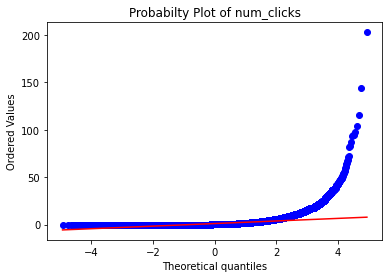

In [18]:
stats.probplot(df['num_clicks'], dist="norm", plot=pylab)
plt.title("Probabilty Plot of num_clicks")
pylab.show()

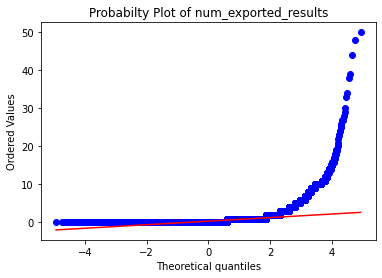

In [19]:
stats.probplot(df['num_exported_results'], dist="norm", plot=pylab)
plt.title("Probabilty Plot of num_exported_results")
pylab.show()

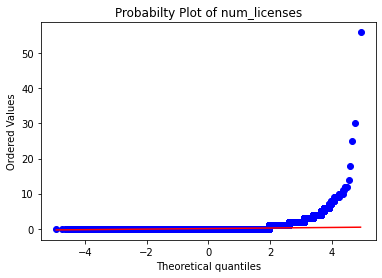

In [20]:
stats.probplot(df['num_licenses'], dist="norm", plot=pylab)
plt.title("Probabilty Plot of num_licenses")
pylab.show()

None of the potential dependent variables have normal distribution. Then, for significance testing, I will use non-parametric tests. Then, for removing outliers, I used percentiles which can remove outliers from a non-normal data. I removed outliers based on num_clicks values. For the upper and lower limits, I selected 1% and 99%. Since most of our values is zero in num_clicks column 1% percentile is still zero and only the upper limit is effective in removing outliers.

In [21]:
lower_limit, upper_limit = np.percentile(df['num_clicks'], 1), np.percentile(df['num_exported_results'], 99)
cleaned_df=df[df['num_clicks'].between(lower_limit, upper_limit)]

After that, I split data based on the experiment_group to get the data in each condition.

In [22]:
grouped_cleaned_df = cleaned_df.groupby('experiment_group')
a_cleaned_df= grouped_cleaned_df.get_group('A')
b_cleaned_df= grouped_cleaned_df.get_group('B')

And then, I check the distribution of user_id, media_types, user_tier, and experiment_day to make sure there is not a significant difference between these distributions that may cause bias in our data.

In [23]:
a_cleaned_df.shape, b_cleaned_df.shape

((785342, 11), (789287, 11))

In [24]:
b_cleaned_df.value_counts('user_id'), a_cleaned_df.value_counts('user_id')

(user_id
 73fda8af    398
 dd5aa59f    260
 5034f339    256
 220463b6    244
 303ee6c4    211
            ... 
 a06e96cf      1
 a06e7e9a      1
 a06e745a      1
 a06e02c9      1
 ffff8a16      1
 Length: 270633, dtype: int64,
 user_id
 5f5250c0    614
 fd5e10ac    298
 5ec61977    286
 a112b0a0    228
 65906bba    204
            ... 
 71109129      1
 7110a903      1
 7110e36a      1
 7110e3ad      1
 ffffd954      1
 Length: 271757, dtype: int64)

In [25]:
a_cleaned_df.value_counts('user_tier'), b_cleaned_df.value_counts('user_tier')

(user_tier
 free    551320
 paid    234022
 dtype: int64,
 user_tier
 free    552768
 paid    236519
 dtype: int64)

In [26]:
a_cleaned_df.value_counts('media_types'), b_cleaned_df.value_counts('media_types')

(media_types
 RV    779586
 V       2898
 R       2858
 dtype: int64,
 media_types
 RV    783918
 R       3151
 V       2218
 dtype: int64)

The data is very unbalanced on these independent variables. For instance, some participants contributed over 200 rows of data while some others have only a few rows which may bias the results toward the behaviour of the highly contributed participants. In a real-world task, I would check the impact of this imbalance in data by checking their significance and if it is significant, I would balance the data over these variables by downsampling. However, it may make this task complicated; then, I assume these imbalanced distributions do not impact the outcome.

<h2>Analysis</h2>


<h3>Section 1: Engagement with Search Results  </h3>


In this part, I want to see the engagement of users with the search results. For this part, I defined these metrics:
<ul>
  <li><b>Click Success Rate</b> : Percentage of queries that got at least a click from user</li>
  <li><b>export Success Rate</b> : Percentage of queries that got at least an export from user
</li>
  <li><b>Paid Success Rate</b> : Percentage of queries that at least got paid for one item </li>
</ul>

These are self-defined metrics. The assumption behind these metrics was that a set of result is more successful if the user opens the items, download them or pay for them. I am unfamiliar with the metric that assesses the quality of search results and could not find anything that fits this problem when I searched for it and because of that I came up with these metrics.

<h4>Analysis on Click Success Rate in condition A, B: </h4>

Text(0.5, 1.0, 'Distribution of num_clicks in different conditions')

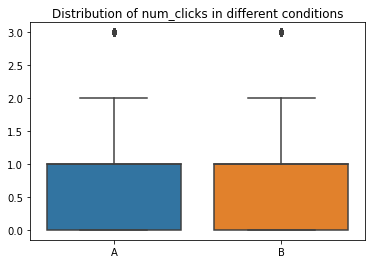

In [55]:
data = pd.DataFrame({
    'A': a_cleaned_df['num_clicks'],
    'B':b_cleaned_df['num_clicks']
})

sns.boxplot(data=data)
plt.title('Distribution of num_clicks in different conditions')

In [56]:
A_click_success_rate= 1-( a_cleaned_df['num_clicks'].value_counts()[0]/ a_cleaned_df['num_clicks'].count())
B_click_success_rate= 1-( b_cleaned_df['num_clicks'].value_counts()[0]/ b_cleaned_df['num_clicks'].count())

In [57]:
A_click_success_rate, B_click_success_rate

(0.5067410121959605, 0.5366425647451434)

Condition B has a slightly higher success rate. To make sure the difference is significant, I ran Mann–Whitney U test and the results show that the difference is significant.

In [58]:
num_click_A= a_cleaned_df['num_clicks']
num_click_B= b_cleaned_df['num_clicks']
stats.mannwhitneyu(a_cleaned_df['num_clicks'],b_cleaned_df['num_clicks']) 

MannwhitneyuResult(statistic=298917578418.5, pvalue=0.0)

In [59]:
percentage= (B_click_success_rate-A_click_success_rate)/A_click_success_rate
print(percentage)

0.059007563685450765


Then, we can say automatic elevation engage 5.9% more user with the search results in terms of opening an item in the search results.

----------------------------------------------------------------------------------

<h4>Analysis on Export Succes Rate in condition A, B: </h4>

I did the same type of analysis for export success rate.

Text(0.5, 1.0, 'Distribution of num_exported_results in different conditions')

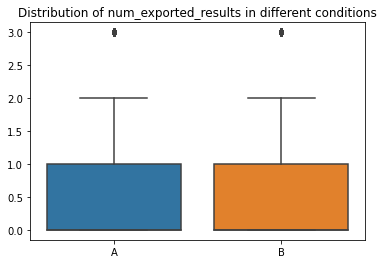

In [69]:
data = pd.DataFrame({
    'A': a_cleaned_df['num_exported_results'],
    'B':b_cleaned_df['num_exported_results']
})

sns.boxplot(data=data)
plt.title('Distribution of num_exported_results in different conditions')

In [70]:
A_export_success_rate= 1-( a_cleaned_df['num_exported_results'].value_counts()[0]/ a_cleaned_df['num_exported_results'].count())
B_export_success_rate= 1-( b_cleaned_df['num_exported_results'].value_counts()[0]/ b_cleaned_df['num_exported_results'].count())

In [71]:
A_export_success_rate, B_export_success_rate

(0.26277596257426705, 0.2632565847404049)

Condition B has a slightly higher success rate in this case. To make sure the difference is significant, I ran Mann–Whitney U test. The results show that the difference is not significant. Then, adding manual elevation has no impact on the number of exported items compared to automatic elevation.

In [72]:
stats.mannwhitneyu(a_cleaned_df['num_exported_results'],b_cleaned_df['num_exported_results']) 

MannwhitneyuResult(statistic=309814213253.5, pvalue=0.5952113599010627)

------------------------------------------------------------------

<h4>Analysis on Paid Succes Rate in condition A, B: </h4>

Again, I did the same type of analysis for paid success rate.

Text(0.5, 1.0, 'Distribution of num_licenses in different conditions')

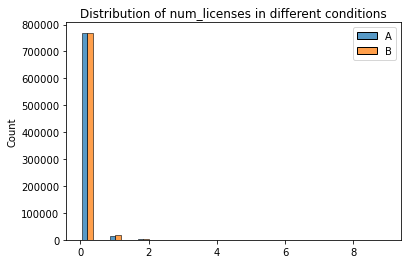

In [73]:
data = pd.DataFrame({
    'A': a_cleaned_df['num_licenses'],
    'B':b_cleaned_df['num_licenses']
})

sns.histplot(data=data,multiple="dodge", shrink=.8)
plt.title('Distribution of num_licenses in different conditions')

In [74]:
A_paid_success_rate= 1-( a_cleaned_df['num_licenses'].value_counts()[0]/ a_cleaned_df['num_licenses'].count())
B_paid_success_rate= 1-( b_cleaned_df['num_licenses'].value_counts()[0]/ b_cleaned_df['num_licenses'].count())

In [75]:
A_paid_success_rate,B_paid_success_rate

(0.020370742937471875, 0.02468810458046311)

In [76]:
stats.mannwhitneyu(a_cleaned_df['num_licenses'],b_cleaned_df['num_licenses']) 

MannwhitneyuResult(statistic=308594477471.5, pvalue=3.742793142401375e-74)

For the paid success rate, condition B has a slightly higher success rate and Mann–Whitney U test shows that it is significant. Then, we can say automatic elevations lead to a higher number of paid downloads.

In [77]:
percentage= (B_paid_success_rate-A_paid_success_rate)/A_paid_success_rate

Then, we can say automatic elevation lead to 21.1% more queries with paid items.
To sum up, automatic elevations showed better results overal, in terms of engaging users with the results and encouraging them to buy.

-----------------------------------------------------------------------------

<h3>Section 2: Effectiveness of Each Method  </h3>


In the second part of my analysis, I want to investigate which method is more effective (or faster) in leading users to their desired image when they get related results (The results get at least one click) to their query. To study this, I defined a new metric. The definition is as follows:
<ul>
  <li>Export per Click Rate: The rate of export per click, among the sets of results that at least get on click from the user.
  </li>
 </ul>
I assumed an item is the desired item of a user when they export it. I measured this metric as follows:

In [78]:
non_zero_clicks_a= a_cleaned_df[a_cleaned_df['num_clicks'] !=0]
non_zero_clicks_b= b_cleaned_df[b_cleaned_df['num_clicks'] !=0]

In [79]:
CTE_A= non_zero_clicks_a['num_exported_results']/non_zero_clicks_a['num_clicks']
CTE_B= non_zero_clicks_b['num_exported_results']/non_zero_clicks_b['num_clicks']

In [80]:
CTE_A.mean(),CTE_B.mean()

(0.44783083939545215, 0.4173188688080441)

In [81]:
stats.mannwhitneyu(CTE_A,CTE_B) 

MannwhitneyuResult(statistic=87155589598.0, pvalue=3.937914065413762e-190)

The results showed users find their desired item faster with manual leveation. In the other words, they have to view less item before they get their desired item. 

In [82]:
(CTE_A.mean()-CTE_B.mean())/CTE_B.mean()

0.07311428470645737

From this results, we can conclude that users find their desired items 7% faster using manual elevation if they get related results.

---------------------------------------------------------------------------

<h3>Section 3: Gain in Purchases</h3>

Previously, we saw users in condition B tend to buy more. For this part, I want to measure the gain in condition B over Condition A.
I assumed the extra value (paid amount) only comes from free users as the paid tier won't be charged extra for downloading the premium items. This may not be true in the real world, but with the limited information I have and testing the website, I made this assumption.

In [83]:
grouped_a = a_cleaned_df.groupby('user_tier')
a_free_df= grouped_a .get_group('free')

grouped_b = b_cleaned_df.groupby('user_tier')
b_free_df= grouped_b.get_group('free')
print(b_free_df['num_licenses'].mean()-a_free_df['num_licenses'].mean())

0.0008990234409240951


Multiplying the aformentioned number by average item price will give us the gain we get from using automatic leverage. 

In [84]:
gain= (b_free_df['num_licenses'].mean()-a_free_df['num_licenses'].mean())/a_free_df['num_licenses'].mean()
print(gain)

0.635448209551631


Or we can say transisioning from manual elevations to automatic elevations can increase the gain by 63%.

------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h2>Conclusion</h2>


Looking back at the results of our analysis, We can conclude that the automatic elevation method performs much better in terms of engaging users and increasing purchases and it is superior to the manual elevation method overally. 